## Sanity check: synthetic data

Generate synthetic data with known dimensionality. TODO

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns

from src import svca
from src.utils import scree_plot

sns.set_context("poster")
sns.set_palette("colorblind")

In [3]:
# Parameters - many more samples than neurons (not necessarily true in real life)
N_SAMPLES = 10000
N_NEURONS = 1000
SEED = 123
RANK = 10 # Dimensionality of low rank data
POWER = -1.5 # Dimensionality of power law data
SIGMA = 1 # amount of independent noise

## Binary on/off manifold

Low-rank data with equal variance along all manifold directions. 

Add independent noise to each neuron that is either homoscedastic (i.e., equally distributed) or heteroscedastic (unequally distributed). 

In [4]:
def low_rank_data(n_samples, n_neurons, rank, sigma, seed = None, homoscedastic=True):
    # Generate some low-rank data (based on scikit-learn example)
    rng = np.random.RandomState(seed)
    U, _, _ = linalg.svd(rng.randn(n_neurons, n_neurons))
    X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

    if homoscedastic: # Adding homoscedastic noise
        X += sigma * rng.randn(n_samples, n_neurons)
    else: # Adding heteroscedastic noise
        sigmas = sigma * rng.rand(n_neurons) + sigma / 2.0
        X += rng.randn(n_samples, n_neurons) * sigmas

    # Neurons are interchangable - simply index them by equally spaced 'position'
    position = np.arange(0, n_neurons)
    return X, position

X, position = low_rank_data(N_SAMPLES, N_NEURONS, RANK, SIGMA, True)

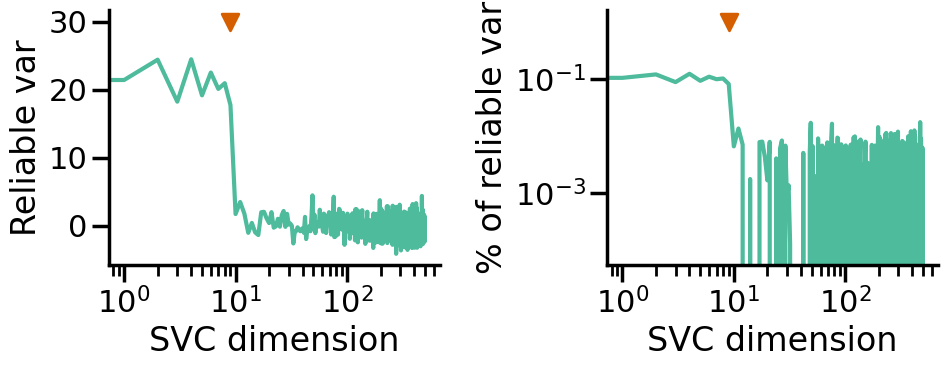

In [5]:
Ftrain, Ftest, Gtrain, Gtest = svca.split_data(X, position)
reliable_variance, all_variance, _, _ = svca.svca(Ftrain, Ftest, Gtrain, Gtest)
fig, ax = scree_plot(reliable_variance, all_variance, RANK, "")

## Power law spectrum

Most real neural data does not live on a manifold with equal-variance dimensions. An example is data whose spectrum follows a power law. 

In [6]:
def power_law_data(n_samples, n_neurons, power, sigma, seed = None, plot = False):
    # Generate some data with a power law spectrum, i.e.
    # dimension n has variance n^{power}
    assert power <= -1 # Want to converge
    rng = np.random.RandomState(seed)
    S = np.arange(1, n_neurons+1, dtype=float)**power # The power law

    # Generate the covariance  - could use any ortho matrix U
    U, _, _ = linalg.svd(rng.randn(n_neurons, n_neurons))
    C = U @ np.diag(S) @ U.T # Covariance
    _, S_hat, _ = linalg.svd(C) # estimate power law
    if plot: # Sanity check
        plt.loglog(S / S.max())
        plt.loglog(S_hat / S_hat.max(), linestyle=":")

    # Generate activity: random loadings + idd noise
    C += np.eye(n_neurons) * sigma
    X = rng.multivariate_normal(np.zeros((n_neurons, )), C, (n_samples, ))

    _, S_hat, _ = linalg.svd(X.T @ X)
    if plot: # Sanity check
        plt.loglog(S_hat / S_hat.max(), linestyle=":")

    # Neurons are interchangable
    position = np.arange(n_neurons, )
    return X, position

On/off manifold distinction is gradual; use a smaller sigma

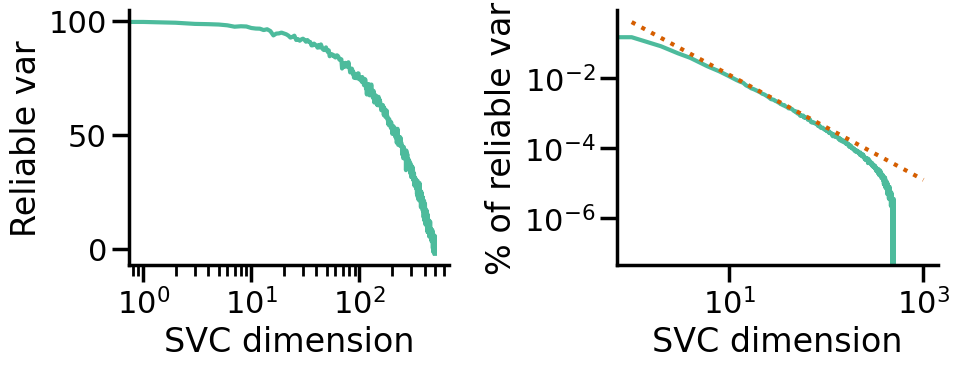

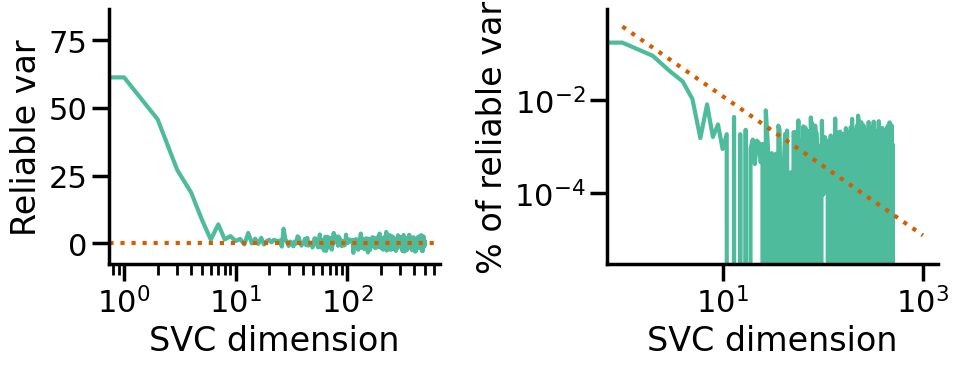

In [7]:
for sigma in [0, SIGMA/10]:
    X, position = power_law_data(N_SAMPLES, N_NEURONS, POWER, sigma, SEED, False)
    Ftrain, Ftest, Gtrain, Gtest = svca.split_data(X, position)
    reliable_variance, all_variance, _, _ = svca.svca(Ftrain, Ftest, Gtrain, Gtest)
    fig, ax = scree_plot(reliable_variance, all_variance)
    x = np.arange(1, 1000, dtype=float)
    # True exponent and noise floor
    ax[1].plot(x, x**POWER / sum(x**POWER ), linestyle=":",color=sns.color_palette()[3])
    if sigma > 0: # Noise floor
        ax[0].hlines(sigma, 0, N_NEURONS, linestyle=":", color=sns.color_palette()[3])

The estimated spectrum is inevitably closer to the "true" spectrum for low off-manifold noise. 

In the presence of noise, the estimated spectrum is a lower-bound on the true spectrum (see Stringer et al. appendix). 

Exercise: vary the amount of iid noise and the sample size, and compare the dimensionality estimated using SVCA with that estimated using PCA without cross-validation, or with cross-validation along the time (but not neuron) axis. 